<a href="https://colab.research.google.com/github/rchecnes/ActionAI/blob/master/3_Recognition_Actions_Final_UPC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Guía original 
https://learnopencv.com/introduction-to-video-classification-and-human-activity-recognition/

Ejemplo 2
https://pyimagesearch.com/2019/07/15/video-classification-with-keras-and-deep-learning/

**1. Instalar librerias**

In [ ]:
!pip install pafy youtube-dl moviepy

**2. Importar librearias**

In [ ]:
import os
import cv2
import math
import pafy
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from moviepy.editor import *
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2007040/45929032 bytes (4.4%)4579328/45929032 bytes (10.0%)7585792/45929032 bytes (16.5%)9838592/45929032 bytes (21.4%)12664832/45929032 bytes (27.6%)15286272/45929032 bytes (33.3%)17719296/45929032 bytes (38.6%)20176896/45929032 bytes (43.9%)22642688/45929032 bytes (49.3%)25272320/45929032 bytes (55.0%)27385856/45929032 bytes (59.6%)30048256/45929032 bytes (65.4%)3

In [ ]:
seed_constant = 23
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

**3. Descargamos videos para entrenar**

In [ ]:
!wget -nc --no-check-certificate https://gitlab.com/rchecnes/videodetectiontea/-/archive/master/videodetectiontea-master.zip
!unzip videodetectiontea-master.zip

--2022-04-10 16:14:26--  https://gitlab.com/rchecnes/videodetectiontea/-/archive/master/videodetectiontea-master.zip
Resolving gitlab.com (gitlab.com)... 172.65.251.78, 2606:4700:90:0:f22e:fbec:5bed:a9b9
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘videodetectiontea-master.zip’

videodetectiontea-m     [                 <=>] 768.68M   100MB/s    in 24s     

2022-04-10 16:14:50 (32.2 MB/s) - ‘videodetectiontea-master.zip’ saved [806020586]

Archive:  videodetectiontea-master.zip
b02afa39f4b5a2d770300eff6b5e56493811d826
   creating: videodetectiontea-master/
   creating: videodetectiontea-master/UCF50/
   creating: videodetectiontea-master/UCF50/All/
   creating: videodetectiontea-master/UCF50/All/ArmFlapping/
  inflating: videodetectiontea-master/UCF50/All/ArmFlapping/v_ArmFlapping_01.mp4  
  inflating: videodetectiontea-master/UCF50/All/ArmFlapping/v_ArmFlapping_0

**Copiar UCF50 en el nivel /content**
Luego elimina el zip y la carpetas de video de gitlab

In [ ]:
mv videodetectiontea-master/UCF50 /content/UCF50

In [ ]:
rm -rf videodetectiontea-master

In [ ]:
rm videodetectiontea-master.zip

In [ ]:
rm -rf UCF50/Training/.gitkeep

**Visualiza los Datos con sus Etiquetas**

Elijamos algunos videos aleatorios de cada clase del conjunto de datos y mostrémoslos, esto nos dará una buena visión general de cómo se ve el conjunto de datos.

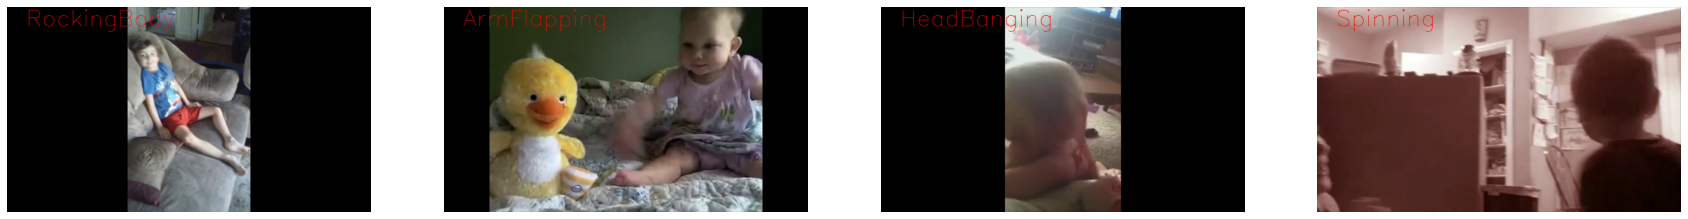

In [ ]:
#Cantidad de acciones
cant_actions = 4

#Create a Matplotlib figure
plt.figure(figsize = (30, 30))

#Nombre de carpeta
name_folder ='UCF50/All'

# Get Names of all classes in UCF50
all_classes_names = os.listdir(name_folder)

# Generate a random sample of images each time the cell runs
random_range = random.sample(range(len(all_classes_names)), cant_actions)

# Iterating through all the random samples
for counter, random_index in enumerate(random_range, 1):

    # Getting Class Name using Random Index
    selected_class_Name = all_classes_names[random_index]
    
    # Getting a list of all the video files present in a Class Directory
    video_files_names_list = os.listdir(f'{name_folder}/{selected_class_Name}')
    
    # Randomly selecting a video file
    selected_video_file_name = random.choice(video_files_names_list)
    
    # Reading the Video File Using the Video Capture
    
    video_reader = cv2.VideoCapture(f'{name_folder}/{selected_class_Name}/{selected_video_file_name}')
    
    # Reading The First Frame of the Video File
    _, bgr_frame = video_reader.read()
    
    # Closing the VideoCapture object and releasing all resources. 
    video_reader.release()

    # Converting the BGR Frame to RGB Frame 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
    
    # Adding The Class Name Text on top of the Video Frame.
    cv2.putText(rgb_frame, selected_class_Name, (100, 100), cv2.FONT_HERSHEY_SIMPLEX, 4, (255, 0, 0), 2)
    
    # Assigning the Frame to a specific position of a subplot
    plt.subplot(5, 4, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')
    

**4. Visualizamos grupo de acciones de videos**

In [ ]:
all_classes_names = os.listdir('UCF50/All')
print(all_classes_names)

['ArmFlapping', 'Spinning', 'RockingBody', 'HeadBanging']


**5: Leer y preprocesar el conjunto de datos**

In [ ]:
image_height, image_width = 64, 64
max_images_per_class = 3200

dataset_directory = "UCF50/All"
classes_list = ["ArmFlapping","HeadBanging","Spinning","RockingBody"]

model_output_size = len(classes_list)

4


**6. Extraer, redimensionar y normalizar marcos**

In [ ]:
def frames_extraction(video_path):
    # Empty List declared to store video frames
    frames_list = []
    
    # Reading the Video File Using the VideoCapture
    video_reader = cv2.VideoCapture(video_path)

    # Iterating through Video Frames
    while True:

        # Reading a frame from the video file 
        success, frame = video_reader.read() 

        # If Video frame was not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (image_height, image_width))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Appending the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Closing the VideoCapture object and releasing all resources. 
    video_reader.release()

    # returning the frames list 
    return frames_list

**7. Creación de conjuntos de datos**

In [ ]:
def create_dataset():

    # Declaring Empty Lists to store the features and labels values.
    temp_features = [] 
    features = []
    labels = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(classes_list):
        print(f'Extracting Data of Class: {class_name}')
        
        # Getting the list of video files present in the specific class name directory
        files_list = os.listdir(os.path.join(dataset_directory, class_name))
        
        
        # Iterating through all the files present in the files list
        for file_name in files_list:

            # Construct the complete video path
            video_file_path = os.path.join(dataset_directory, class_name, file_name)
            
            # Calling the frame_extraction method for every video file path
            frames = frames_extraction(video_file_path)
            
            # Appending the frames to a temporary list.
            temp_features.extend(frames)
            
        
        # Adding randomly selected frames to the features list
        features.extend(random.sample(temp_features, max_images_per_class))
        
        # Adding Fixed number of labels to the labels list
        labels.extend([class_index] * max_images_per_class)
        
        # Emptying the temp_features list so it can be reused to store all frames of the next class.
        temp_features.clear()

    # Converting the features and labels lists to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  

    return features, labels

**Llamar al método create_dataset que devuelve características y etiquetas**

In [ ]:
features, labels = create_dataset()


Extracting Data of Class: ArmFlapping
Extracting Data of Class: HeadBanging
Extracting Data of Class: Spinning
Extracting Data of Class: RockingBody


In [ ]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

**8: Divida los datos en conjuntos de prueba y tren**

In [ ]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.2, shuffle = True, random_state = seed_constant)

**9: Construir la modelo**

In [ ]:
# Let's create a function that will construct our model
def create_model():

    # We will use a Sequential model for model construction
    model = Sequential()

    # Defining The Model Architecture
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', input_shape = (image_height, image_width, 3)))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(model_output_size, activation = 'softmax'))

    # Printing the models summary
    model.summary()

    return model


# Calling the create_model method
model = create_model()

print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 batch_normalization (BatchN  (None, 60, 60, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 64)       0         
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 64)               0         
 lobalAveragePooling2D)                                          
                                                        

**10: Compilar y entrenar el modelo**

In [ ]:
# Adding Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

# Adding loss, optimizer and metrics values to the model.
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start Training
model_training_history = model.fit(x = features_train, y = labels_train, epochs = 60, batch_size = 4 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/60
2048/2048 [==============================] - 228s 111ms/step - loss: 1.0919 - accuracy: 0.5420 - val_loss: 1.2660 - val_accuracy: 0.6382
Epoch 2/60
2048/2048 [==============================] - 227s 111ms/step - loss: 0.6434 - accuracy: 0.7649 - val_loss: 0.8631 - val_accuracy: 0.6187
Epoch 3/60
2048/2048 [==============================] - 227s 111ms/step - loss: 0.4280 - accuracy: 0.8511 - val_loss: 0.1434 - val_accuracy: 0.9551
Epoch 4/60
2048/2048 [==============================] - 228s 111ms/step - loss: 0.3365 - accuracy: 0.8831 - val_loss: 0.1240 - val_accuracy: 0.9609
Epoch 5/60
2048/2048 [==============================] - 227s 111ms/step - loss: 0.2764 - accuracy: 0.9059 - val_loss: 0.1857 - val_accuracy: 0.9263
Epoch 6/60
2048/2048 [==============================] - 229s 112ms/step - loss: 0.2344 - accuracy: 0.9216 - val_loss: 0.0847 - val_accuracy: 0.9673
Epoch 7/60
2048/2048 [==============================] - 229s 112ms/step - loss: 0.2386 - accuracy: 0.9197 - val_

**11: Evaluación de su modelo entrenado**

In [ ]:
model_evaluation_history = model.evaluate(features_test, labels_test)

80/80 [==============================] - 15s 192ms/step - loss: 0.0015 - accuracy: 1.0000


**12: Guarde su modelo**

In [ ]:
# Creating a useful name for our model, incase you're saving multiple models (OPTIONAL)
date_time_format = '%Y%m%d_%H%M%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
model_name = f'Model_DateTime_{current_date_time_string}_Loss_{round(model_evaluation_loss,4)}_Accuracy_{round(model_evaluation_accuracy,4)}.h5'

# Saving your Model
model.save(model_name)

**Matriz de confusion**

**Curvas de pérdida y precisión del modelo de trazado**
Ahora crearemos una función plot_metric() para visualizar las métricas de entrenamiento y validación. Ya tenemos métricas separadas de nuestros pasos de capacitación y validación, así que ahora solo tenemos que visualizarlas.

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

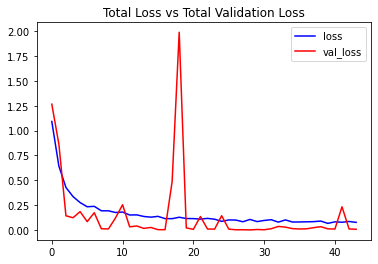

In [ ]:
plot_metric(model_training_history,'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

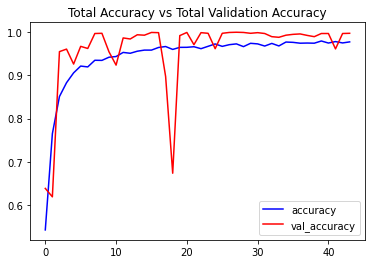

In [32]:
plot_metric(model_training_history,'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

**Matriz de confusión**